In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

2024-05-14 14:00:41.933244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 14:00:41.933351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 14:00:42.020391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Exploring dataset
base_dir = '../input/chest-xray-pneumonia/chest_xray/'

train_pneumonia_dir = base_dir + 'train/PNEUMONIA/'
train_normal_dir = base_dir + 'train/NORMAL/'

test_pneumonia_dir = base_dir + 'test/PNEUMONIA/'
test_normal_dir = base_dir + 'test/NORMAL/'

val_normal_dir = base_dir + 'val/NORMAL/'
val_pneumonia_dir = base_dir + 'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir + "{}".format(i) for i in os.listdir(train_pneumonia_dir)]
train_normal = [train_normal_dir + "{}".format(i) for i in os.listdir(train_normal_dir)]

test_normal = [test_normal_dir + "{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir + "{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn = [val_pneumonia_dir + "{}".format(i) for i in os.listdir(val_pneumonia_dir)]
val_normal = [val_normal_dir + "{}".format(i) for i in os.listdir(val_normal_dir)]

print("Total images:", len(train_pn + train_normal + test_normal + test_pn + val_pn + val_normal))
print("Total pneumonia images:", len(train_pn + test_pn + val_pn))
print("Total normal images:", len(train_normal + test_normal + val_normal))



Total images: 5856
Total pneumonia images: 4273
Total normal images: 1583


In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the data
def load_data(img_paths, label):
    data = []
    labels = []
    for img_path in img_paths:
        img_arr = img_to_array(load_img(img_path, target_size=(224, 224)))
        data.append(img_arr)
        labels.append(label)
    return data, labels

# Loading data
train_pn_data, train_pn_labels = load_data(train_pn, 1)
train_normal_data, train_normal_labels = load_data(train_normal, 0)
test_pn_data, test_pn_labels = load_data(test_pn, 1)
test_normal_data, test_normal_labels = load_data(test_normal, 0)
val_pn_data, val_pn_labels = load_data(val_pn, 1)
val_normal_data, val_normal_labels = load_data(val_normal, 0)

# Combine data and labels
X = np.array(train_pn_data + train_normal_data + test_pn_data + test_normal_data + val_pn_data + val_normal_data)
y = np.array(train_pn_labels + train_normal_labels + test_pn_labels + test_normal_labels + val_pn_labels + val_normal_labels)

# Splitting data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [4]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the conventional CNN model
model = Sequential([
    Input(shape=(224, 224, 3)),  # Use Input layer to define the input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
# Train the conventional CNN model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50
)



Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/147 ━━━━━━━━━━━━━━━━━━━━ 28:12 12s/step - accuracy: 0.4062 - loss: 0.7184

I0000 00:00:1715695354.665684     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715695354.683451     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7319 - loss: 1.0034

W0000 00:00:1715695402.345032     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 61s 336ms/step - accuracy: 0.7328 - loss: 0.9971 - val_accuracy: 0.8464 - val_loss: 21.2415
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 293ms/step - accuracy: 0.8714 - loss: 0.3276 - val_accuracy: 0.9078 - val_loss: 14.6067
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 288ms/step - accuracy: 0.8927 - loss: 0.2724 - val_accuracy: 0.8669 - val_loss: 13.3917
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 290ms/step - accuracy: 0.8881 - loss: 0.2712 - val_accuracy: 0.8072 - val_loss: 41.6026
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 44s 287ms/step - accuracy: 0.8977 - loss: 0.2623 - val_accuracy: 0.8959 - val_loss: 11.3752
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 44s 288ms/step - accuracy: 0.9007 - loss: 0.2423 - val_accuracy: 0.8754 - val_loss: 22.4322
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 294ms/step - accuracy: 0.9062 - loss: 0.2338 - val_accuracy: 0.8669 - val_loss: 20.7985
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 290ms/step - accuracy: 0.9103 - loss: 0.222

In [7]:
# Evaluate the conventional CNN model
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Accuracy: 0.8276450511945392
Precision: 0.816247582205029
Recall: 0.985981308411215
F1 Score: 0.8931216931216932


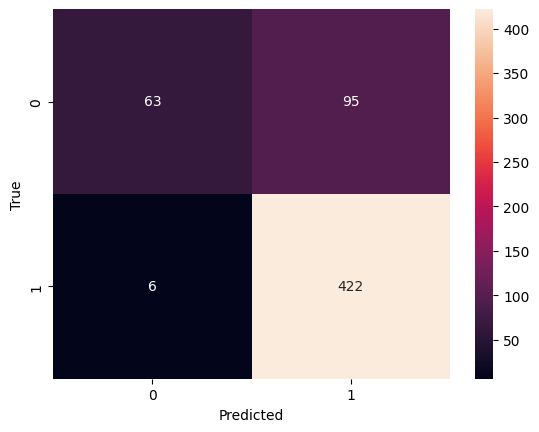

In [8]:
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


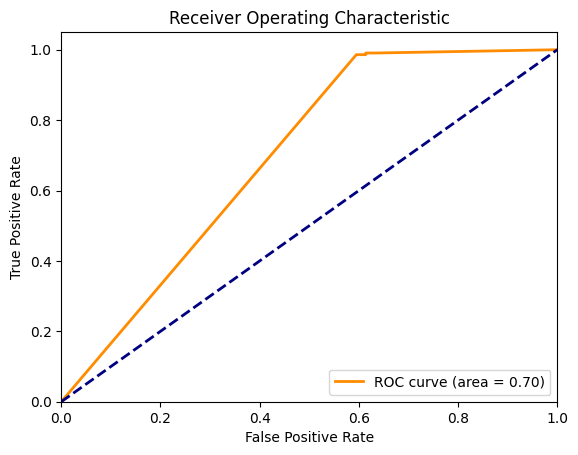

In [9]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the trained model
model.save('/kaggle/working/conventional_cnn_model.h5')


In [10]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_pretrained = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model_pretrained.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the pre-trained CNN model
history_pretrained = model_pretrained.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50
)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


133/147 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step - accuracy: 0.7825 - loss: 0.4400

W0000 00:00:1715697707.979997     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 496ms/step - accuracy: 0.7876 - loss: 0.4315 - val_accuracy: 0.2713 - val_loss: 38.3147
Epoch 2/50


W0000 00:00:1715697726.854461     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 311ms/step - accuracy: 0.9011 - loss: 0.2535 - val_accuracy: 0.3038 - val_loss: 31.7114
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - accuracy: 0.9116 - loss: 0.2325 - val_accuracy: 0.3635 - val_loss: 26.8855
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 310ms/step - accuracy: 0.9219 - loss: 0.2083 - val_accuracy: 0.5529 - val_loss: 16.9034
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 311ms/step - accuracy: 0.9255 - loss: 0.1992 - val_accuracy: 0.5922 - val_loss: 15.0278
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 311ms/step - accuracy: 0.9300 - loss: 0.1813 - val_accuracy: 0.6553 - val_loss: 12.2166
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 308ms/step - accuracy: 0.9231 - loss: 0.1900 - val_accuracy: 0.7253 - val_loss: 9.3227
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - accuracy: 0.9346 - loss: 0.1698 - val_accuracy: 0.7031 - val_loss: 10.4496
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 309ms/step - accuracy: 0.9299 - loss: 0.1784

In [11]:
# Evaluate the pre-trained CNN model
y_pred_pretrained = (model_pretrained.predict(X_test) > 0.5).astype(int).flatten()
accuracy_pretrained = accuracy_score(y_test, y_pred_pretrained)
precision_pretrained = precision_score(y_test, y_pred_pretrained)
recall_pretrained = recall_score(y_test, y_pred_pretrained)
f1_pretrained = f1_score(y_test, y_pred_pretrained)
cm_pretrained = confusion_matrix(y_test, y_pred_pretrained)

# Print evaluation metrics for the pre-trained model
print(f"Pre-trained Model Accuracy: {accuracy_pretrained}")
print(f"Pre-trained Model Precision: {precision_pretrained}")
print(f"Pre-trained Model Recall: {recall_pretrained}")
print(f"Pre-trained Model F1 Score: {f1_pretrained}")



19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Pre-trained Model Accuracy: 0.7593856655290102
Pre-trained Model Precision: 0.7934560327198364
Pre-trained Model Recall: 0.9065420560747663
Pre-trained Model F1 Score: 0.846237731733915


W0000 00:00:1715700066.640179     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


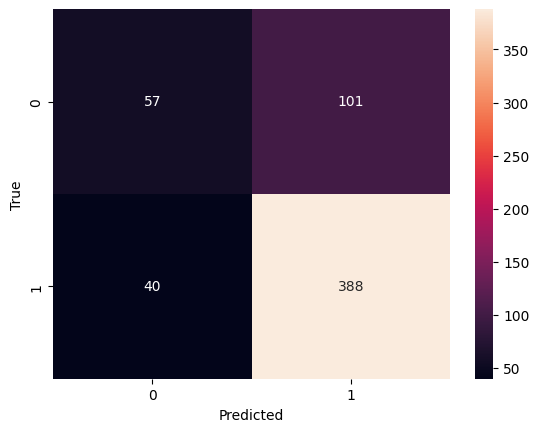

In [12]:
# Plot confusion matrix for pre-trained model
sns.heatmap(cm_pretrained, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step


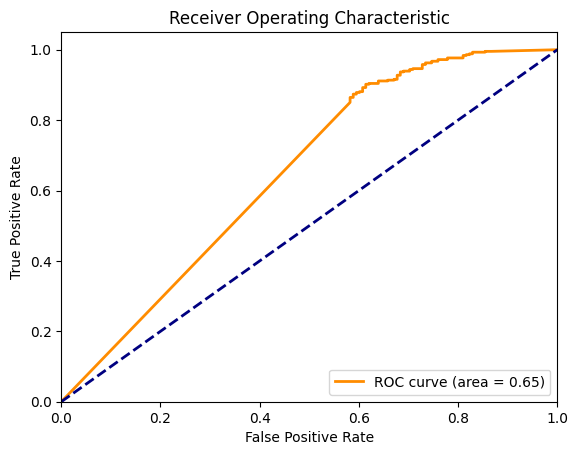

In [13]:
# Plot ROC curve for pre-trained model
fpr_pretrained, tpr_pretrained, _ = roc_curve(y_test, model_pretrained.predict(X_test))
roc_auc_pretrained = auc(fpr_pretrained, tpr_pretrained)
plt.figure()
plt.plot(fpr_pretrained, tpr_pretrained, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_pretrained)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the pre-trained model
model_pretrained.save('/kaggle/working/pretrained_cnn_model.h5')
